##**Fetching and Preparing the data**

In [0]:
from google.colab import drive
import numpy as np
from PIL import Image
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
#added to be able to read from google drive
drive.mount('/content/drive')
dataset = []

for person in range(1, 41):
    for img in range(1, 11):
        #edited to be able to read from google drive
        folder_path = '/content/drive/My Drive/dataset/att_faces/s' + str(person) + '/'

        image = Image.open(folder_path + str(img) + '.pgm')
        vec = np.array(image).reshape(10304)

        dataset.append(vec)

D = np.array([example for example in dataset])
D = D.reshape((400, 10304))

#Genrating the label vector
labels =[]

for i in range(1, 41):
    labels.append(i * np.ones((10, 1)))
y = np.stack(labels, axis=0).reshape(400, 1)

#odd rows for training
x_train = D[::2]
y_train = y[::2]

#even rows for test
x_test = D[1::2]
y_test = y[1::2]



##**PCA Calculation**

In [0]:
from numpy import linalg

alphas = [0.80, 0.85, 0.90, 0.95]
Ks = [1,3,5,7]
mean = np.mean(x_train, axis=0)
centered_data = x_train - mean
covariance = (centered_data.T.dot(centered_data))/len(x_train)

In [0]:

pca_evalues, pca_evectors = linalg.eigh(covariance)
x = pca_evalues.argsort()[::-1]
pca_evalues = pca_evalues[x]
pca_evectors = pca_evectors[:,x]


In [0]:
#calculating number of eigen values needed
def count_eigenV(pca_evalues, alpha):
    total = sum(pca_evalues)
    current_sum = 0.0
    counter = 0
    while current_sum/total < alpha:
        current_sum += pca_evalues[counter]
        counter += 1
    return counter

#projecting train and test on projection matrix
def project(PJmat, train_data, test_data):
    PJmat = PJmat.transpose()
    prj_train = np.dot(train_data, PJmat)
    prj_test = np.dot(test_data, PJmat)
    return prj_train, prj_test

#k-neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
def Kneighb(k,train,test,testLabel,aplha,y_train):
    model = KNeighborsClassifier(n_neighbors=k)
    FitModel = model.fit(train, y_train)
    predictions = model.predict(test)
    accuracy = round(accuracy_score(testLabel, predictions), 2)
    print("For alpha = ",aplha, "and k = ",k, "Accuracy = ",accuracy)
    return accuracy

In [0]:
count_80 = count_eigenV(pca_evalues, 0.80)
count_85 = count_eigenV(pca_evalues, 0.85)
count_90 = count_eigenV(pca_evalues, 0.90)
count_95 = count_eigenV(pca_evalues, 0.95)

#clac projection matrix for each alpha

prj_mat80 = np.vstack(pca_evectors.T[0:count_80])
prj_mat85 = np.vstack(pca_evectors.T[0:count_85])
prj_mat90 = np.vstack(pca_evectors.T[0:count_90])
prj_mat95 = np.vstack(pca_evectors.T[0:count_95])

PJtrain80, PJtest80 = project(prj_mat80, x_train, x_test)
PJtrain85, PJtest85 = project(prj_mat85, x_train, x_test)
PJtrain90, PJtest90 = project(prj_mat90, x_train, x_test)
PJtrain95, PJtest95 = project(prj_mat95, x_train, x_test)

#converting label from nd array to 1d array *needed in k-nearest*
y_rtrain = y_train.ravel()
y_rtest = y_test.ravel()



For alpha =  0.8 and k =  1 Accuracy =  0.95

For alpha =  0.85 and k =  1 Accuracy =  0.95

For alpha =  0.9 and k =  1 Accuracy =  0.94

For alpha =  0.95 and k =  1 Accuracy =  0.94

For alpha =  0.8 and k =  3 Accuracy =  0.9

For alpha =  0.85 and k =  3 Accuracy =  0.9

For alpha =  0.9 and k =  3 Accuracy =  0.89

For alpha =  0.95 and k =  3 Accuracy =  0.9

For alpha =  0.8 and k =  5 Accuracy =  0.85

For alpha =  0.85 and k =  5 Accuracy =  0.84

For alpha =  0.9 and k =  5 Accuracy =  0.84

For alpha =  0.95 and k =  5 Accuracy =  0.84

For alpha =  0.8 and k =  7 Accuracy =  0.8

For alpha =  0.85 and k =  7 Accuracy =  0.78

For alpha =  0.9 and k =  7 Accuracy =  0.77

For alpha =  0.95 and k =  7 Accuracy =  0.74



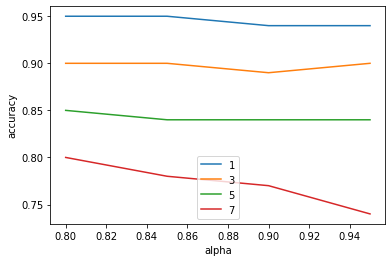

In [0]:
#converting all labels from float to int alson needed in k nearest 
y_train_ready = list(map(int, y_rtrain))
y_test_ready = list(map(int, y_rtest))

#have fun!
import matplotlib.pyplot as plt

i = 0
for i in range(4):
  x = []
  x.append(Kneighb(Ks[i],PJtrain80,PJtest80,y_test_ready,0.80,y_train_ready))
  print("")
  x.append(Kneighb(Ks[i],PJtrain85,PJtest85,y_test_ready,0.85,y_train_ready))
  print("")
  x.append(Kneighb(Ks[i],PJtrain90,PJtest90,y_test_ready,0.90,y_train_ready))
  print("")
  x.append(Kneighb(Ks[i],PJtrain95,PJtest95,y_test_ready,0.95,y_train_ready))
  print("")
  plt.plot([0.8,0.85,0.9,0.95],x)
  #plt.show() #to show each graph of alpha individually
plt.xlabel("alpha")  
plt.ylabel("accuracy")
plt.legend(["1","3","5","7"])  
plt.show()




##**LDA Calculation**

In [0]:
def LinearDiscriminant(D, y):

    print("@ Partioning the dataset into class-specific subsets...")
    #partioning the dataset into class-specific subsets
    classes = []
    for label in range(1, 41):
        classes.append(
            [D[i] for i in range(200) if y[i] == label]
        )
    classed_dataset = np.array(classes)

    print("@ Computing the mean vector for each class...")
    mean_vectors = np.zeros((40, 10304))
    for i in range(40):
        mean_vectors[i, :] = np.mean(classed_dataset[i], axis=0)


    print("@ Computing the between-class scatter matrix...")
    #overall mean
    overall_mean = np.mean(D, axis=0).reshape(1, 10304)
    #Calulating the between-class scatter matrix
    Sb = np.zeros((10304, 10304))

    for j in range(40):
        Sb += len(classed_dataset[j]) * np.outer((np.array(mean_vectors[j, :]) - overall_mean), (np.transpose(mean_vectors[j, :] - overall_mean)))
    print("     - Between-class scatter matrix: %sx%s" % (Sb.shape[0], Sb.shape[1]))

    # Center the class matrices.
    print("@ Centering the dataset...")
    sc = StandardScaler()
    class_data = []
    for i in range(40):
        class_data.append(sc.fit_transform(classed_dataset[i]))

    print("@ Computing the between-class scatter matrix...")
    #within-class scatter matrices
    Sw = np.zeros((10304, 10304), dtype='float64')
    for each_class in range(40):
        Si = np.zeros((10304, 10304))
        for each_example in range(5):
            example = class_data[each_class][each_example].reshape(10304, 1)
            class_mean = mean_vectors[each_class, :].reshape(10304, 1)
            Si += np.outer((example - class_mean), ((example - class_mean).T))  # compute the class-specific scatter matrix.
    Sw += Si

    print("     - Within-class scatter matrix: %s x %s" % (Sw.shape[0], Sw.shape[1]))

    # Compute the dominant eigenvectors.
    print('@ Computing eigenvectors & eigenvalues:')
    eigen_values, eigen_vectors = np.linalg.eigh(np.linalg.pinv(Sw).dot(Sb))
    
    # Make a list of (eigenvalue, eigenvector) pairs
    print('     - Making pairs of (eigenvectors & eigenvalues) and sorting them in descending order corresponding to eigenvalues...')
    eigen_pairs = [(np.abs(eigen_values[i]), eigen_vectors[:,i].real) for i in range(len(eigen_values))]

    # Sort the (eigenvalue, eigenvector) tuples from high to low
    eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)

    # Use 39 dominant eigenvectors to form the projection matrix.
    U = np.hstack((eigen_pairs[0][1][:, np.newaxis],
                   eigen_pairs[1][1][:, np.newaxis],
                   eigen_pairs[2][1][:, np.newaxis],
                   eigen_pairs[3][1][:, np.newaxis],
                   eigen_pairs[4][1][:, np.newaxis],
                   eigen_pairs[5][1][:, np.newaxis],
                   eigen_pairs[6][1][:, np.newaxis],
                   eigen_pairs[7][1][:, np.newaxis],
                   eigen_pairs[8][1][:, np.newaxis],
                   eigen_pairs[9][1][:, np.newaxis],
                   eigen_pairs[10][1][:, np.newaxis],
                   eigen_pairs[11][1][:, np.newaxis],
                   eigen_pairs[12][1][:, np.newaxis],
                   eigen_pairs[13][1][:, np.newaxis],
                   eigen_pairs[14][1][:, np.newaxis],
                   eigen_pairs[15][1][:, np.newaxis],
                   eigen_pairs[16][1][:, np.newaxis],
                   eigen_pairs[17][1][:, np.newaxis],
                   eigen_pairs[18][1][:, np.newaxis],
                   eigen_pairs[19][1][:, np.newaxis],
                   eigen_pairs[20][1][:, np.newaxis],
                   eigen_pairs[21][1][:, np.newaxis],
                   eigen_pairs[22][1][:, np.newaxis],
                   eigen_pairs[23][1][:, np.newaxis],
                   eigen_pairs[24][1][:, np.newaxis],
                   eigen_pairs[25][1][:, np.newaxis],
                   eigen_pairs[26][1][:, np.newaxis],
                   eigen_pairs[27][1][:, np.newaxis],
                   eigen_pairs[28][1][:, np.newaxis],
                   eigen_pairs[29][1][:, np.newaxis],
                   eigen_pairs[30][1][:, np.newaxis],
                   eigen_pairs[31][1][:, np.newaxis],
                   eigen_pairs[32][1][:, np.newaxis],
                   eigen_pairs[33][1][:, np.newaxis],
                   eigen_pairs[34][1][:, np.newaxis],
                   eigen_pairs[35][1][:, np.newaxis],
                   eigen_pairs[36][1][:, np.newaxis],
                   eigen_pairs[37][1][:, np.newaxis],
                   eigen_pairs[38][1][:, np.newaxis]
                   ))

    print('\n-------------------------------------------------------------------------------------------------')
    print('\n@ Matrix U:\n', U)
    print('\n-------------------------------------------------------------------------------------------------')
    return U, Sw


In [0]:
U, Sw = LinearDiscriminant(x_train, y_train)
print('\n@ Within-class scatter matrix Sw: \n', Sw)
print('\n-------------------------------------------------------------------------------------------------')
print('@ Projecting the data: ')
# Projecting the training data
projection_natrix_train = x_train.dot(U)
print('projection train:\n', projection_natrix_train)
print('\n-------------------------------------------------------------------------------------------------')
# Projecting the test data
projection_natrix_test = x_test.dot(U)

@ Partioning the dataset into class-specific subsets...
@ Computing the mean vector for each class...
@ Computing the between-class scatter matrix...
     - Between-class scatter matrix: 10304x10304
@ Centering the dataset...
@ Computing the between-class scatter matrix...
     - Within-class scatter matrix: 10304 x 10304
@ Computing eigenvectors & eigenvalues:
     - Making pairs of (eigenvectors & eigenvalues) and sorting them in descending order corresponding to eigenvalues...

-------------------------------------------------------------------------------------------------

@ Matrix U:
 [[ 1.74168566e-01 -2.02439814e-01  1.81360299e-01 ...  6.69448753e-04
  -3.02478388e-04 -1.19883878e-04]
 [ 1.64766616e-01 -2.14652056e-01  2.08296922e-01 ... -5.07428409e-04
  -4.87350189e-04  2.19601772e-05]
 [ 1.81831211e-01 -1.88256637e-01  1.40768173e-01 ... -1.31081541e-04
   1.29051132e-04  5.55390784e-05]
 ...
 [-1.34852216e-04 -1.34120066e-04 -1.18861711e-04 ... -9.08157405e-03
   5.5131572


@ Using KNN classifier: 
k=1  0.935
k=3  0.87
k=5  0.775
k=7  0.73


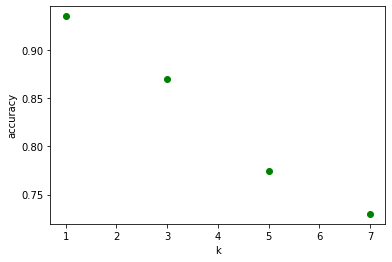

In [0]:
print('\n@ Using KNN classifier: ')
x_lda = []
# Use a k Nearest Neighbor classifier to classify the data.
classifier = KNeighborsClassifier(n_neighbors=1)
classifier.fit(projection_natrix_train, y_train.ravel())
y_pred = classifier.predict(projection_natrix_test)
print("k=1 ", metrics.accuracy_score(y_test, y_pred))
x_lda.append(metrics.accuracy_score(y_test, y_pred))

classifier = KNeighborsClassifier(n_neighbors=3)
classifier.fit(projection_natrix_train, y_train.ravel())
y_pred = classifier.predict(projection_natrix_test)
print("k=3 ", metrics.accuracy_score(y_test, y_pred))
x_lda.append(metrics.accuracy_score(y_test, y_pred))

classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(projection_natrix_train, y_train.ravel())
y_pred = classifier.predict(projection_natrix_test)
print("k=5 ", metrics.accuracy_score(y_test, y_pred))
x_lda.append(metrics.accuracy_score(y_test, y_pred))

classifier = KNeighborsClassifier(n_neighbors=7)
classifier.fit(projection_natrix_train, y_train.ravel())
y_pred = classifier.predict(projection_natrix_test)
print("k=7 ", metrics.accuracy_score(y_test, y_pred))
x_lda.append(metrics.accuracy_score(y_test, y_pred))

plt.xlabel("k")  
plt.ylabel("accuracy")
plt.plot([1,3,5,7],x_lda , 'go')
plt.show()

##**If we change the train-test distribution to 70-30**


In [0]:
from google.colab import drive
import numpy as np
from PIL import Image
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
#added to be able to read from google drive
drive.mount('/content/drive')
dataset = []

for person in range(1, 41):
    for img in range(1, 11):
        #edited to be able to read from google drive
        folder_path = '/content/drive/My Drive/dataset/att_faces/s' + str(person) + '/'

        image = Image.open(folder_path + str(img) + '.pgm')
        vec = np.array(image).reshape(10304)

        dataset.append(vec)

D = np.array([example for example in dataset])
D = D.reshape((400, 10304))

#Genrating the label vector
labels =[]

for i in range(1, 41):
    labels.append(i * np.ones((10, 1)))
y = np.stack(labels, axis=0).reshape(400, 1)

x_train = []
y_train = []
x_test = []
y_test = []
#first 7 rows for training and 3 for testing
for i in range(D.shape[0]):
  if i%10 < 7 : 
    x_train.append(D[i])
    y_train.append(y[i])
  else :
    x_test.append(D[i])
    y_test.append(y[i])

print(len(x_train))
print(len(x_test))

##**PCA Calculation**

In [0]:
alphas = [0.80, 0.85, 0.90, 0.95]
Ks = [1,3,5,7]
mean = np.mean(x_train, axis=0)
centered_data = x_train - mean
covariance = (centered_data.T.dot(centered_data))/len(x_train)
pca_evalues, pca_evectors = linalg.eigh(covariance)
x = pca_evalues.argsort()[::-1]
pca_evalues = pca_evalues[x]
pca_evectors = pca_evectors[:,x]

For alpha =  0.8 and k =  1 Accuracy =  0.96

For alpha =  0.85 and k =  1 Accuracy =  0.97

For alpha =  0.9 and k =  1 Accuracy =  0.97

For alpha =  0.95 and k =  1 Accuracy =  0.95

For alpha =  0.8 and k =  3 Accuracy =  0.92

For alpha =  0.85 and k =  3 Accuracy =  0.93

For alpha =  0.9 and k =  3 Accuracy =  0.92

For alpha =  0.95 and k =  3 Accuracy =  0.94

For alpha =  0.8 and k =  5 Accuracy =  0.91

For alpha =  0.85 and k =  5 Accuracy =  0.91

For alpha =  0.9 and k =  5 Accuracy =  0.89

For alpha =  0.95 and k =  5 Accuracy =  0.9

For alpha =  0.8 and k =  7 Accuracy =  0.84

For alpha =  0.85 and k =  7 Accuracy =  0.84

For alpha =  0.9 and k =  7 Accuracy =  0.85

For alpha =  0.95 and k =  7 Accuracy =  0.8



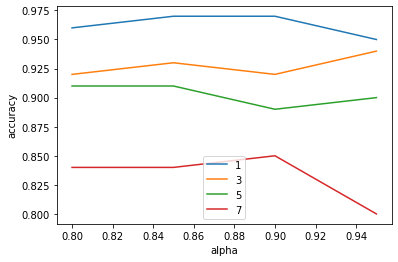

In [0]:
count_80 = count_eigenV(pca_evalues, 0.80)
count_85 = count_eigenV(pca_evalues, 0.85)
count_90 = count_eigenV(pca_evalues, 0.90)
count_95 = count_eigenV(pca_evalues, 0.95)

#clac projection matrix for each alpha

prj_mat80 = np.vstack(pca_evectors.T[0:count_80])
prj_mat85 = np.vstack(pca_evectors.T[0:count_85])
prj_mat90 = np.vstack(pca_evectors.T[0:count_90])
prj_mat95 = np.vstack(pca_evectors.T[0:count_95])

PJtrain80, PJtest80 = project(prj_mat80, x_train, x_test)
PJtrain85, PJtest85 = project(prj_mat85, x_train, x_test)
PJtrain90, PJtest90 = project(prj_mat90, x_train, x_test)
PJtrain95, PJtest95 = project(prj_mat95, x_train, x_test)

#converting all labels from float to int alson needed in k nearest 
y_train_ready = list(map(int, y_train))
y_test_ready = list(map(int, y_test))

#have fun!
import matplotlib.pyplot as plt

i = 0
for i in range(4):
  x = []
  x.append(Kneighb(Ks[i],PJtrain80,PJtest80,y_test_ready,0.80,y_train_ready))
  print("")
  x.append(Kneighb(Ks[i],PJtrain85,PJtest85,y_test_ready,0.85,y_train_ready))
  print("")
  x.append(Kneighb(Ks[i],PJtrain90,PJtest90,y_test_ready,0.90,y_train_ready))
  print("")
  x.append(Kneighb(Ks[i],PJtrain95,PJtest95,y_test_ready,0.95,y_train_ready))
  print("")
  plt.plot([0.8,0.85,0.9,0.95],x)
  #plt.show() #to show each graph of alpha individually
plt.xlabel("alpha")  
plt.ylabel("accuracy")
plt.legend(["1","3","5","7"])  
plt.show()
